## _*Qiskit Chemistry, H2O ground state computation*_

This notebook demonstrates how to use Qiskit Chemistry to compute the ground state energy of a water (H2O) molecule using VQE and UCCSD.

While the molecule has been input below to the driver in xyz format, the Z-matrix format is also support. H2O in Z-matrix format would look like this 
```
H; O 1 1.08; H 2 1.08 1 104.5
```
and is convenient when the goal is to change bond angle, or plot the energy changing distance(s) while preserving the angle.

This notebook has been written to use the PYSCF chemistry driver. 

In [1]:
import numpy as np
import pylab

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import NumPyMinimumEigensolver

from qiskit_algorithms.optimizers import SLSQP

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator

First we create and run a driver to produce our molecule object. The molecule object holds data from the drivers in a common way so it can then be used independently of which specific driver created it.

And let's print some of fields it has.

In [24]:
driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0', charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print(f'Nuclear repulsion energy: {molecule.nuclear_repulsion_energy} Ha')
print(f'Reference energy: {molecule.reference_energy} Ha')
print(f'Number of spin orbitals: {molecule.num_spin_orbitals}')
print(f'Number of alpha electrons: {molecule.num_alpha}')
print(f'Number of beta electrons: {molecule.num_beta}')

Nuclear repulsion energy: 9.193913160623385 Ha
Reference energy: -74.96294665653873 Ha
Number of spin orbitals: 14
Number of alpha electrons: 5
Number of beta electrons: 5


In [27]:
transformer = FreezeCoreTransformer()
transformed_molecule = transformer.transform(molecule)
mapper = ParityMapper(num_particles=transformed_molecule.num_particles)

algo = NumPyMinimumEigensolver()
algo.filter_criterion = transformed_molecule.get_default_filter_criterion()
solver = GroundStateEigensolver(mapper, algo)
op, _ = solver.get_qubit_operators(transformed_molecule)
print(f'Number of qubits: {op.num_qubits}, number of paulis: {len(op.paulis)}')
result = solver.solve(transformed_molecule)
print(result)


Number of qubits: 10, number of paulis: 551
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.206272446429
  - computed part:      -23.544497240444
  - FreezeCoreTransformer extracted energy part: -60.661775205985
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012359285806
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  2.21475902  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  1.578672632401  0.0]
    - computed part:      [0.0  1.577787979435  0.0]
    - FreezeCoreTransformer extracted energy part: [0.0  0.000884652966  0.0]
  > Dipole moment (a.u.): [0.0  0.636086387599  0.0]  Total: 0.636086387599
                 (debye): [0.0  1.616770178304  0.0]  Total: 1.616770178304
 


#### Using VQE

Here we will start with the qubit operator that we computed above. We need to setup an optimizer, variational form and initial state for use with VQE.

The variational form and UCCSD are a little more complex since they need information about numbers of orbitals and numbers of electrons, as well as what qubit mapping etc was used for the qubit operator.

In [32]:
tapered_mapper = transformed_molecule.get_tapered_mapper(mapper)
estimator = Estimator()

optimizer = SLSQP(maxiter=10000, ftol=1e-9)
ansatz = UCCSD(
    transformed_molecule.num_spatial_orbitals,
    transformed_molecule.num_particles,
    tapered_mapper,
    initial_state=HartreeFock(
    transformed_molecule.num_spatial_orbitals,
    transformed_molecule.num_particles,
    tapered_mapper,
    )
)
vqe = VQE(estimator, ansatz, optimizer)
vqe.initial_point = [0] * ansatz.num_parameters
solver = GroundStateEigensolver(tapered_mapper, vqe)
op, _ = solver.get_qubit_operators(transformed_molecule)
print(f'Number of qubits: {op.num_qubits}, number of paulis: {len(op.paulis)}')

result = solver.solve(transformed_molecule)
print(result)

Number of qubits: 8, number of paulis: 514
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.20617191118
  - computed part:      -23.544396705194
  - FreezeCoreTransformer extracted energy part: -60.661775205985
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012258750556
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  2.21475902  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [None  1.578671818463  None]
    - computed part:      [None  1.577787165497  None]
    - FreezeCoreTransformer extracted energy part: [0.0  0.000884652966  0.0]
  > Dipole moment (a.u.): [None  0.636087201537  None]  Total: None
                 (debye): [None  1.616772247128  None]  Total: None
 


#### Z-matrix format

Z-matrix was mentioned in the introduction. Lets show it in use in a quick final example here. We'll use NumPyMinimumEigensolver as the goal here is just to show the technique. We will keep the bond angle between the Hydrogen atoms and Oxygen constant while varying the interatomic distance of one the Hydrogen atoms. This is simple to do in Z-matrix format, though can of course be done using xyz format but that needs more work to compute the coordinates each time.

In [46]:
distances = [x * 0.01 + 1.0 for x in range(15)]
energies = np.empty(len(distances))

for i, distance in enumerate(distances):
    driver = PySCFDriver(f'H; O 1 1.08; H 2 {distance} 1 104.5', basis='sto3g')
    molecule = driver.run()
    transformer = FreezeCoreTransformer()
    transformed_molecule = transformer.transform(molecule)
    mapper = ParityMapper(num_particles=transformed_molecule.num_particles)
    algo = NumPyMinimumEigensolver()
    algo.filter_criterion = transformed_molecule.get_default_filter_criterion()
    solver = GroundStateEigensolver(mapper, algo)
    result = solver.solve(transformed_molecule)
    energies[i] = result.total_energies[0]
    

Text(0.5, 1.0, 'H2O molecule, one H atom distance varied')

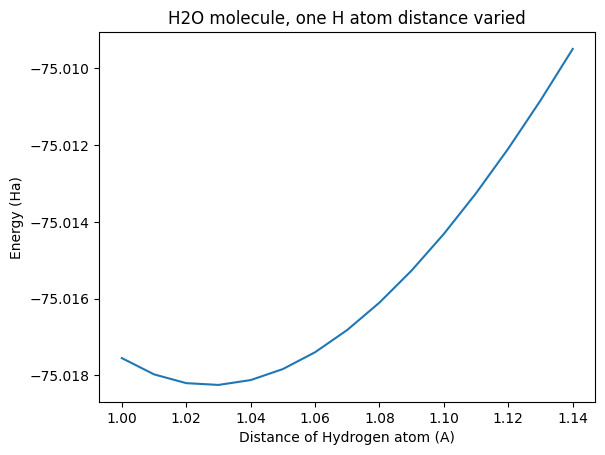

In [47]:
pylab.plot(distances, energies)
pylab.xlabel('Distance of Hydrogen atom (A)')
pylab.ylabel('Energy (Ha)')
pylab.title('H2O molecule, one H atom distance varied')

In [35]:
! pip freeze | grep qiskit

qiskit==1.1.0
qiskit-aer==0.14.2
qiskit-algorithms==0.3.0
qiskit-ibm-runtime==0.25.0
qiskit-machine-learning==0.7.2
qiskit-nature==0.7.2
qiskit-nature-pyscf==0.4.0
qiskit-qasm3-import==0.5.0
qiskit-transpiler-service==0.4.5
